<a href="https://colab.research.google.com/github/mbraihan/MA_2/blob/main/COMP_6321_MA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 1**

*In this question, you will explore the concept of Transfer Learning (TL) using PyTorch. TL is a technique in which previously trained models can be used to help train new models. There are two possible ways to implemented TL, namely Fine-tuning and Feature Extraction. You can read more about these methods by referring to PyTorch documentations. For the following questions, you are to use the Brain Tumor classification dataset available on Kaggle. Sample images are shown below for the 4 different classes.*

**Download data**

In [1]:
!gdown 1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
!unzip /content/brain_tumor.zip

Downloading...
From: https://drive.google.com/uc?id=1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
To: /content/brain_tumor.zip
100% 62.3M/62.3M [00:02<00:00, 25.5MB/s]
Archive:  /content/brain_tumor.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jp

##### *Import libraries*

In [6]:
import os
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import shutil
import random
from tqdm import tqdm


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

*a) Analyze and visualize the statistics of the dataset. Pre-process the data and prepare them for the training phase. Ensure that the images are resized to $224 \times 224 \times 3$ and normalized. Split the data randomly into train and test sets, with a ratio of $7: 3$.*

**Load the data, Split the data into 70% training and 30% testing**

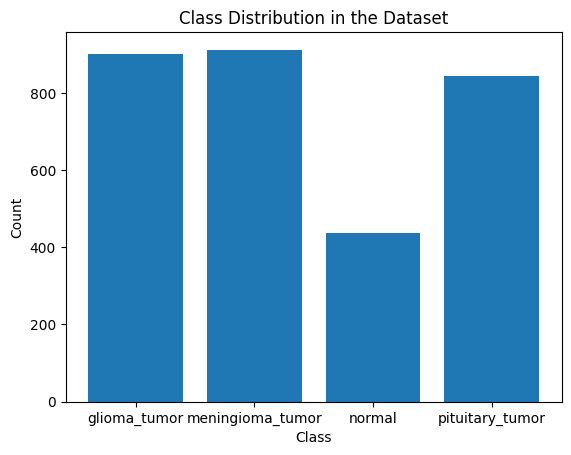

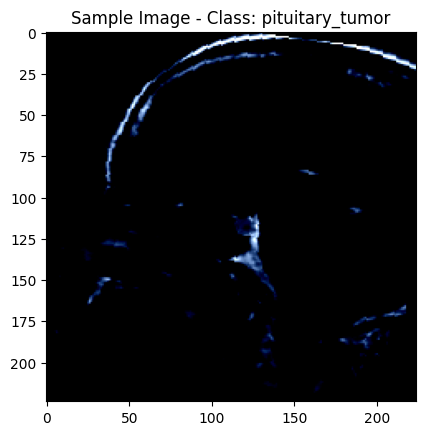

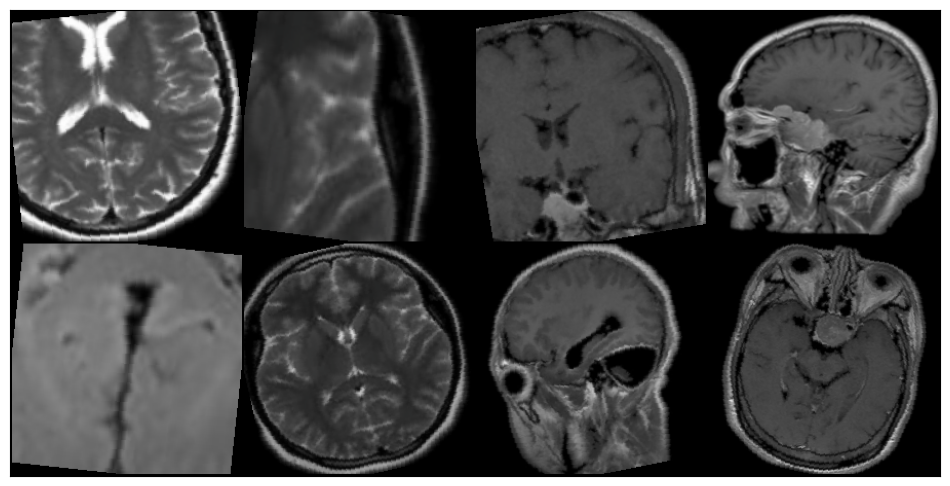

In [3]:
dataset_path = '/content/Data'


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

# Create a custom dataset
brain_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

batch_size = 32
data_loader = DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)

class_counts = torch.bincount(torch.tensor(brain_dataset.targets))
unique_classes = [brain_dataset.classes[i] for i in range(len(class_counts)) if class_counts[i] > 0]

plt.bar(unique_classes, class_counts[class_counts > 0].numpy())
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Split the data into train and test sets (7:3 ratio)
train_indices, test_indices = train_test_split(list(range(len(brain_dataset))), test_size=0.3, random_state=42)

# Split the data into train and test sets (7:3 ratio)
train_size = int(0.7 * len(brain_dataset))
test_size = len(brain_dataset) - train_size
train_dataset, test_dataset = random_split(brain_dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display a sample image
sample_image, sample_label = next(iter(train_loader))
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title(f'Sample Image - Class: {brain_dataset.classes[sample_label[0]]}')
plt.show()

stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dltrain_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:8], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

*b) Train a ResNet-18 model from scratch using the provided dataset for the classification task. You are free to choose the hyperparameters (batch size, learning rate, optimizer, loss function, etc).*

***Model***

In [4]:
# Load pretrained  ResNet18 model
model = models.resnet18(pretrained=False)

num_classes = len(brain_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

***Train***

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define a variable to store the best validation accuracy
best_acc = 0.0

# Lists to store train and test loss and accuracy
train_loss_list = []
train_accuary_list = []
test_loss_list = []
test_accuary_list = []

# Train model
num_epochs = 100

for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch+1))

    # Training
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

        scheduler.step()

    # Calculate training accuracy
    epoch_train_acc = corrects.double() / total_samples * 100.0
    epoch_train_loss = running_loss / len(train_loader)

    train_loss_list.append(epoch_train_loss)
    train_accuary_list.append(epoch_train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Validation #{epoch+1}")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

    # Calculate validation accuracy
    epoch_test_acc = corrects.double() / total_samples * 100.0
    epoch_test_loss = running_loss / len(test_loader)

    test_loss_list.append(epoch_test_loss)
    test_accuary_list.append(epoch_test_acc)

    # Print and save the model with the best test accuracy
    print('[Epoch {}] Training Loss: {:.4f} Acc: {:.4f}% | Validation Loss: {:.4f} Acc: {:.4f}%'.format(
        epoch+1, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))

    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print('Training complete!')

Epoch 1 running


Validation #1: 100%|██████████| 30/30 [00:04<00:00,  6.13batch/s, accuracy=0.572, loss=0.0366]


[Epoch 1] Training Loss: 0.5003 Acc: 57.1582% | Validation Loss: 1.1341 Acc: 57.1582%
Epoch 2 running


Validation #2: 100%|██████████| 30/30 [00:06<00:00,  4.87batch/s, accuracy=0.715, loss=0.0246]


[Epoch 2] Training Loss: 0.3357 Acc: 71.4747% | Validation Loss: 0.7608 Acc: 71.4747%
Epoch 3 running


Validation #3: 100%|██████████| 30/30 [00:04<00:00,  6.12batch/s, accuracy=0.758, loss=0.0224]


[Epoch 3] Training Loss: 0.3058 Acc: 75.7804% | Validation Loss: 0.6931 Acc: 75.7804%
Epoch 4 running


Validation #4: 100%|██████████| 30/30 [00:06<00:00,  4.81batch/s, accuracy=0.753, loss=0.0231]


[Epoch 4] Training Loss: 0.3157 Acc: 75.3498% | Validation Loss: 0.7156 Acc: 75.3498%
Epoch 5 running


Validation #5: 100%|██████████| 30/30 [00:04<00:00,  6.20batch/s, accuracy=0.674, loss=0.0397]


[Epoch 5] Training Loss: 0.5430 Acc: 67.3843% | Validation Loss: 1.2308 Acc: 67.3843%
Epoch 6 running


Validation #6: 100%|██████████| 30/30 [00:05<00:00,  5.24batch/s, accuracy=0.766, loss=0.0207]


[Epoch 6] Training Loss: 0.2821 Acc: 76.6416% | Validation Loss: 0.6395 Acc: 76.6416%
Epoch 7 running


Validation #7: 100%|██████████| 30/30 [00:04<00:00,  6.26batch/s, accuracy=0.783, loss=0.0205]


[Epoch 7] Training Loss: 0.2807 Acc: 78.2562% | Validation Loss: 0.6362 Acc: 78.2562%
Epoch 8 running


Validation #8: 100%|██████████| 30/30 [00:07<00:00,  4.28batch/s, accuracy=0.773, loss=0.0225]


[Epoch 8] Training Loss: 0.3077 Acc: 77.2874% | Validation Loss: 0.6975 Acc: 77.2874%
Epoch 9 running


Validation #9: 100%|██████████| 30/30 [00:04<00:00,  6.36batch/s, accuracy=0.769, loss=0.0215]


[Epoch 9] Training Loss: 0.2943 Acc: 76.8568% | Validation Loss: 0.6670 Acc: 76.8568%
Epoch 10 running


Validation #10: 100%|██████████| 30/30 [00:06<00:00,  4.94batch/s, accuracy=0.8, loss=0.019]


[Epoch 10] Training Loss: 0.2592 Acc: 79.9785% | Validation Loss: 0.5875 Acc: 79.9785%
Epoch 11 running


Validation #11: 100%|██████████| 30/30 [00:04<00:00,  6.27batch/s, accuracy=0.779, loss=0.0192]


[Epoch 11] Training Loss: 0.2623 Acc: 77.9333% | Validation Loss: 0.5945 Acc: 77.9333%
Epoch 12 running


Validation #12: 100%|██████████| 30/30 [00:05<00:00,  5.41batch/s, accuracy=0.795, loss=0.0201]


[Epoch 12] Training Loss: 0.2745 Acc: 79.5479% | Validation Loss: 0.6221 Acc: 79.5479%
Epoch 13 running


Validation #13: 100%|██████████| 30/30 [00:04<00:00,  6.18batch/s, accuracy=0.787, loss=0.0193]


[Epoch 13] Training Loss: 0.2642 Acc: 78.6868% | Validation Loss: 0.5989 Acc: 78.6868%
Epoch 14 running


Validation #14: 100%|██████████| 30/30 [00:05<00:00,  5.72batch/s, accuracy=0.789, loss=0.0207]


[Epoch 14] Training Loss: 0.2830 Acc: 78.9020% | Validation Loss: 0.6415 Acc: 78.9020%
Epoch 15 running


Validation #15: 100%|██████████| 30/30 [00:04<00:00,  6.05batch/s, accuracy=0.773, loss=0.0187]


[Epoch 15] Training Loss: 0.2558 Acc: 77.2874% | Validation Loss: 0.5799 Acc: 77.2874%
Epoch 16 running


Validation #16: 100%|██████████| 30/30 [00:05<00:00,  5.78batch/s, accuracy=0.786, loss=0.0213]


[Epoch 16] Training Loss: 0.2905 Acc: 78.5791% | Validation Loss: 0.6585 Acc: 78.5791%
Epoch 17 running


Validation #17: 100%|██████████| 30/30 [00:05<00:00,  5.70batch/s, accuracy=0.788, loss=0.0217]


[Epoch 17] Training Loss: 0.2958 Acc: 78.7944% | Validation Loss: 0.6705 Acc: 78.7944%
Epoch 18 running


Validation #18: 100%|██████████| 30/30 [00:04<00:00,  6.10batch/s, accuracy=0.788, loss=0.0214]


[Epoch 18] Training Loss: 0.2928 Acc: 78.7944% | Validation Loss: 0.6637 Acc: 78.7944%
Epoch 19 running


Validation #19: 100%|██████████| 30/30 [00:05<00:00,  5.59batch/s, accuracy=0.799, loss=0.0174]


[Epoch 19] Training Loss: 0.2374 Acc: 79.8708% | Validation Loss: 0.5382 Acc: 79.8708%
Epoch 20 running


Validation #20: 100%|██████████| 30/30 [00:04<00:00,  6.26batch/s, accuracy=0.804, loss=0.0175]


[Epoch 20] Training Loss: 0.2388 Acc: 80.4090% | Validation Loss: 0.5412 Acc: 80.4090%
Epoch 21 running


Validation #21: 100%|██████████| 30/30 [00:05<00:00,  5.40batch/s, accuracy=0.789, loss=0.0202]


[Epoch 21] Training Loss: 0.2758 Acc: 78.9020% | Validation Loss: 0.6251 Acc: 78.9020%
Epoch 22 running


Validation #22: 100%|██████████| 30/30 [00:04<00:00,  6.20batch/s, accuracy=0.795, loss=0.0198]


[Epoch 22] Training Loss: 0.2701 Acc: 79.5479% | Validation Loss: 0.6123 Acc: 79.5479%
Epoch 23 running


Validation #23: 100%|██████████| 30/30 [00:05<00:00,  5.36batch/s, accuracy=0.781, loss=0.0188]


[Epoch 23] Training Loss: 0.2574 Acc: 78.1485% | Validation Loss: 0.5834 Acc: 78.1485%
Epoch 24 running


Validation #24: 100%|██████████| 30/30 [00:04<00:00,  6.31batch/s, accuracy=0.805, loss=0.0186]


[Epoch 24] Training Loss: 0.2543 Acc: 80.5167% | Validation Loss: 0.5765 Acc: 80.5167%
Epoch 25 running


Validation #25: 100%|██████████| 30/30 [00:05<00:00,  5.04batch/s, accuracy=0.777, loss=0.0204]


[Epoch 25] Training Loss: 0.2791 Acc: 77.7180% | Validation Loss: 0.6327 Acc: 77.7180%
Epoch 26 running


Validation #26: 100%|██████████| 30/30 [00:04<00:00,  6.14batch/s, accuracy=0.795, loss=0.019]


[Epoch 26] Training Loss: 0.2593 Acc: 79.5479% | Validation Loss: 0.5877 Acc: 79.5479%
Epoch 27 running


Validation #27: 100%|██████████| 30/30 [00:06<00:00,  4.90batch/s, accuracy=0.792, loss=0.0204]


[Epoch 27] Training Loss: 0.2787 Acc: 79.2250% | Validation Loss: 0.6318 Acc: 79.2250%
Epoch 28 running


Validation #28: 100%|██████████| 30/30 [00:04<00:00,  6.22batch/s, accuracy=0.791, loss=0.0183]


[Epoch 28] Training Loss: 0.2506 Acc: 79.1173% | Validation Loss: 0.5681 Acc: 79.1173%
Epoch 29 running


Validation #29: 100%|██████████| 30/30 [00:06<00:00,  4.98batch/s, accuracy=0.776, loss=0.0203]


[Epoch 29] Training Loss: 0.2777 Acc: 77.6103% | Validation Loss: 0.6295 Acc: 77.6103%
Epoch 30 running


Validation #30: 100%|██████████| 30/30 [00:04<00:00,  6.16batch/s, accuracy=0.804, loss=0.0205]


[Epoch 30] Training Loss: 0.2798 Acc: 80.4090% | Validation Loss: 0.6342 Acc: 80.4090%
Epoch 31 running


Validation #31: 100%|██████████| 30/30 [00:06<00:00,  4.87batch/s, accuracy=0.8, loss=0.0199]


[Epoch 31] Training Loss: 0.2725 Acc: 79.9785% | Validation Loss: 0.6177 Acc: 79.9785%
Epoch 32 running


Validation #32: 100%|██████████| 30/30 [00:04<00:00,  6.10batch/s, accuracy=0.776, loss=0.0202]


[Epoch 32] Training Loss: 0.2755 Acc: 77.6103% | Validation Loss: 0.6246 Acc: 77.6103%
Epoch 33 running


Validation #33: 100%|██████████| 30/30 [00:06<00:00,  4.88batch/s, accuracy=0.789, loss=0.0207]


[Epoch 33] Training Loss: 0.2830 Acc: 78.9020% | Validation Loss: 0.6414 Acc: 78.9020%
Epoch 34 running


Validation #34: 100%|██████████| 30/30 [00:04<00:00,  6.14batch/s, accuracy=0.775, loss=0.0208]


[Epoch 34] Training Loss: 0.2837 Acc: 77.5027% | Validation Loss: 0.6430 Acc: 77.5027%
Epoch 35 running


Validation #35: 100%|██████████| 30/30 [00:05<00:00,  5.10batch/s, accuracy=0.778, loss=0.0203]


[Epoch 35] Training Loss: 0.2779 Acc: 77.8256% | Validation Loss: 0.6299 Acc: 77.8256%
Epoch 36 running


Validation #36: 100%|██████████| 30/30 [00:04<00:00,  6.38batch/s, accuracy=0.778, loss=0.0188]


[Epoch 36] Training Loss: 0.2568 Acc: 77.8256% | Validation Loss: 0.5821 Acc: 77.8256%
Epoch 37 running


Validation #37: 100%|██████████| 30/30 [00:05<00:00,  5.40batch/s, accuracy=0.788, loss=0.0198]


[Epoch 37] Training Loss: 0.2703 Acc: 78.7944% | Validation Loss: 0.6127 Acc: 78.7944%
Epoch 38 running


Validation #38: 100%|██████████| 30/30 [00:04<00:00,  6.03batch/s, accuracy=0.777, loss=0.0198]


[Epoch 38] Training Loss: 0.2701 Acc: 77.7180% | Validation Loss: 0.6123 Acc: 77.7180%
Epoch 39 running


Validation #39: 100%|██████████| 30/30 [00:05<00:00,  5.52batch/s, accuracy=0.769, loss=0.0211]


[Epoch 39] Training Loss: 0.2878 Acc: 76.8568% | Validation Loss: 0.6524 Acc: 76.8568%
Epoch 40 running


Validation #40: 100%|██████████| 30/30 [00:05<00:00,  5.85batch/s, accuracy=0.785, loss=0.0208]


[Epoch 40] Training Loss: 0.2847 Acc: 78.4715% | Validation Loss: 0.6453 Acc: 78.4715%
Epoch 41 running


Validation #41: 100%|██████████| 30/30 [00:05<00:00,  5.71batch/s, accuracy=0.781, loss=0.0219]


[Epoch 41] Training Loss: 0.2992 Acc: 78.1485% | Validation Loss: 0.6781 Acc: 78.1485%
Epoch 42 running


Validation #42: 100%|██████████| 30/30 [00:05<00:00,  5.67batch/s, accuracy=0.791, loss=0.021]


[Epoch 42] Training Loss: 0.2864 Acc: 79.1173% | Validation Loss: 0.6491 Acc: 79.1173%
Epoch 43 running


Validation #43: 100%|██████████| 30/30 [00:04<00:00,  6.11batch/s, accuracy=0.791, loss=0.0202]


[Epoch 43] Training Loss: 0.2757 Acc: 79.1173% | Validation Loss: 0.6249 Acc: 79.1173%
Epoch 44 running


Validation #44: 100%|██████████| 30/30 [00:05<00:00,  5.22batch/s, accuracy=0.789, loss=0.0199]


[Epoch 44] Training Loss: 0.2725 Acc: 78.9020% | Validation Loss: 0.6178 Acc: 78.9020%
Epoch 45 running


Validation #45: 100%|██████████| 30/30 [00:04<00:00,  6.16batch/s, accuracy=0.786, loss=0.0207]


[Epoch 45] Training Loss: 0.2834 Acc: 78.5791% | Validation Loss: 0.6425 Acc: 78.5791%
Epoch 46 running


Validation #46: 100%|██████████| 30/30 [00:05<00:00,  5.35batch/s, accuracy=0.811, loss=0.0203]


[Epoch 46] Training Loss: 0.2772 Acc: 81.0549% | Validation Loss: 0.6284 Acc: 81.0549%
Epoch 47 running


Validation #47: 100%|██████████| 30/30 [00:04<00:00,  6.18batch/s, accuracy=0.771, loss=0.0193]


[Epoch 47] Training Loss: 0.2631 Acc: 77.0721% | Validation Loss: 0.5964 Acc: 77.0721%
Epoch 48 running


Validation #48: 100%|██████████| 30/30 [00:06<00:00,  4.99batch/s, accuracy=0.791, loss=0.0207]


[Epoch 48] Training Loss: 0.2826 Acc: 79.1173% | Validation Loss: 0.6405 Acc: 79.1173%
Epoch 49 running


Validation #49: 100%|██████████| 30/30 [00:04<00:00,  6.23batch/s, accuracy=0.793, loss=0.0189]


[Epoch 49] Training Loss: 0.2588 Acc: 79.3326% | Validation Loss: 0.5867 Acc: 79.3326%
Epoch 50 running


Validation #50: 100%|██████████| 30/30 [00:05<00:00,  5.10batch/s, accuracy=0.778, loss=0.0216]


[Epoch 50] Training Loss: 0.2951 Acc: 77.8256% | Validation Loss: 0.6689 Acc: 77.8256%
Epoch 51 running


Validation #51: 100%|██████████| 30/30 [00:04<00:00,  6.05batch/s, accuracy=0.781, loss=0.0205]


[Epoch 51] Training Loss: 0.2797 Acc: 78.1485% | Validation Loss: 0.6339 Acc: 78.1485%
Epoch 52 running


Validation #52: 100%|██████████| 30/30 [00:06<00:00,  4.89batch/s, accuracy=0.78, loss=0.0196]


[Epoch 52] Training Loss: 0.2676 Acc: 78.0409% | Validation Loss: 0.6066 Acc: 78.0409%
Epoch 53 running


Validation #53: 100%|██████████| 30/30 [00:04<00:00,  6.23batch/s, accuracy=0.785, loss=0.019]


[Epoch 53] Training Loss: 0.2594 Acc: 78.4715% | Validation Loss: 0.5879 Acc: 78.4715%
Epoch 54 running


Validation #54: 100%|██████████| 30/30 [00:06<00:00,  4.94batch/s, accuracy=0.783, loss=0.0206]


[Epoch 54] Training Loss: 0.2809 Acc: 78.2562% | Validation Loss: 0.6367 Acc: 78.2562%
Epoch 55 running


Validation #55: 100%|██████████| 30/30 [00:04<00:00,  6.19batch/s, accuracy=0.785, loss=0.0195]


[Epoch 55] Training Loss: 0.2667 Acc: 78.4715% | Validation Loss: 0.6045 Acc: 78.4715%
Epoch 56 running


Validation #56: 100%|██████████| 30/30 [00:05<00:00,  5.04batch/s, accuracy=0.784, loss=0.0194]


[Epoch 56] Training Loss: 0.2653 Acc: 78.3638% | Validation Loss: 0.6014 Acc: 78.3638%
Epoch 57 running


Validation #57: 100%|██████████| 30/30 [00:04<00:00,  6.11batch/s, accuracy=0.801, loss=0.0179]


[Epoch 57] Training Loss: 0.2446 Acc: 80.0861% | Validation Loss: 0.5544 Acc: 80.0861%
Epoch 58 running


Validation #58: 100%|██████████| 30/30 [00:05<00:00,  5.27batch/s, accuracy=0.781, loss=0.02]


[Epoch 58] Training Loss: 0.2737 Acc: 78.1485% | Validation Loss: 0.6205 Acc: 78.1485%
Epoch 59 running


Validation #59: 100%|██████████| 30/30 [00:04<00:00,  6.22batch/s, accuracy=0.787, loss=0.0215]


[Epoch 59] Training Loss: 0.2940 Acc: 78.6868% | Validation Loss: 0.6664 Acc: 78.6868%
Epoch 60 running


Validation #60: 100%|██████████| 30/30 [00:05<00:00,  5.45batch/s, accuracy=0.772, loss=0.0193]


[Epoch 60] Training Loss: 0.2630 Acc: 77.1798% | Validation Loss: 0.5962 Acc: 77.1798%
Epoch 61 running


Validation #61: 100%|██████████| 30/30 [00:04<00:00,  6.27batch/s, accuracy=0.8, loss=0.019]


[Epoch 61] Training Loss: 0.2602 Acc: 79.9785% | Validation Loss: 0.5898 Acc: 79.9785%
Epoch 62 running


Validation #62: 100%|██████████| 30/30 [00:05<00:00,  5.41batch/s, accuracy=0.776, loss=0.0194]


[Epoch 62] Training Loss: 0.2657 Acc: 77.6103% | Validation Loss: 0.6022 Acc: 77.6103%
Epoch 63 running


Validation #63: 100%|██████████| 30/30 [00:04<00:00,  6.30batch/s, accuracy=0.802, loss=0.0204]


[Epoch 63] Training Loss: 0.2788 Acc: 80.1938% | Validation Loss: 0.6320 Acc: 80.1938%
Epoch 64 running


Validation #64: 100%|██████████| 30/30 [00:05<00:00,  5.45batch/s, accuracy=0.793, loss=0.0212]


[Epoch 64] Training Loss: 0.2900 Acc: 79.3326% | Validation Loss: 0.6572 Acc: 79.3326%
Epoch 65 running


Validation #65: 100%|██████████| 30/30 [00:04<00:00,  6.47batch/s, accuracy=0.773, loss=0.0208]


[Epoch 65] Training Loss: 0.2836 Acc: 77.2874% | Validation Loss: 0.6427 Acc: 77.2874%
Epoch 66 running


Validation #66: 100%|██████████| 30/30 [00:05<00:00,  5.57batch/s, accuracy=0.784, loss=0.0214]


[Epoch 66] Training Loss: 0.2923 Acc: 78.3638% | Validation Loss: 0.6625 Acc: 78.3638%
Epoch 67 running


Validation #67: 100%|██████████| 30/30 [00:04<00:00,  6.25batch/s, accuracy=0.781, loss=0.0212]


[Epoch 67] Training Loss: 0.2897 Acc: 78.1485% | Validation Loss: 0.6567 Acc: 78.1485%
Epoch 68 running


Validation #68: 100%|██████████| 30/30 [00:05<00:00,  5.19batch/s, accuracy=0.787, loss=0.0197]


[Epoch 68] Training Loss: 0.2694 Acc: 78.6868% | Validation Loss: 0.6107 Acc: 78.6868%
Epoch 69 running


Validation #69: 100%|██████████| 30/30 [00:04<00:00,  6.80batch/s, accuracy=0.781, loss=0.0193]


[Epoch 69] Training Loss: 0.2632 Acc: 78.1485% | Validation Loss: 0.5965 Acc: 78.1485%
Epoch 70 running


Validation #70: 100%|██████████| 30/30 [00:05<00:00,  5.19batch/s, accuracy=0.785, loss=0.0198]


[Epoch 70] Training Loss: 0.2705 Acc: 78.4715% | Validation Loss: 0.6132 Acc: 78.4715%
Epoch 71 running


Validation #71: 100%|██████████| 30/30 [00:04<00:00,  6.59batch/s, accuracy=0.78, loss=0.0207]


[Epoch 71] Training Loss: 0.2829 Acc: 78.0409% | Validation Loss: 0.6413 Acc: 78.0409%
Epoch 72 running


Validation #72: 100%|██████████| 30/30 [00:05<00:00,  5.27batch/s, accuracy=0.786, loss=0.0202]


[Epoch 72] Training Loss: 0.2758 Acc: 78.5791% | Validation Loss: 0.6251 Acc: 78.5791%
Epoch 73 running


Validation #73: 100%|██████████| 30/30 [00:04<00:00,  6.63batch/s, accuracy=0.776, loss=0.0199]


[Epoch 73] Training Loss: 0.2716 Acc: 77.6103% | Validation Loss: 0.6157 Acc: 77.6103%
Epoch 74 running


Validation #74: 100%|██████████| 30/30 [00:05<00:00,  5.27batch/s, accuracy=0.79, loss=0.0184]


[Epoch 74] Training Loss: 0.2515 Acc: 79.0097% | Validation Loss: 0.5701 Acc: 79.0097%
Epoch 75 running


Validation #75: 100%|██████████| 30/30 [00:04<00:00,  6.71batch/s, accuracy=0.795, loss=0.0205]


[Epoch 75] Training Loss: 0.2797 Acc: 79.5479% | Validation Loss: 0.6341 Acc: 79.5479%
Epoch 76 running


Validation #76: 100%|██████████| 30/30 [00:05<00:00,  5.68batch/s, accuracy=0.773, loss=0.0199]


[Epoch 76] Training Loss: 0.2713 Acc: 77.2874% | Validation Loss: 0.6150 Acc: 77.2874%
Epoch 77 running


Validation #77: 100%|██████████| 30/30 [00:04<00:00,  6.68batch/s, accuracy=0.798, loss=0.0197]


[Epoch 77] Training Loss: 0.2693 Acc: 79.7632% | Validation Loss: 0.6104 Acc: 79.7632%
Epoch 78 running


Validation #78: 100%|██████████| 30/30 [00:04<00:00,  6.20batch/s, accuracy=0.789, loss=0.0206]


[Epoch 78] Training Loss: 0.2817 Acc: 78.9020% | Validation Loss: 0.6385 Acc: 78.9020%
Epoch 79 running


Validation #79: 100%|██████████| 30/30 [00:04<00:00,  6.01batch/s, accuracy=0.781, loss=0.0186]


[Epoch 79] Training Loss: 0.2545 Acc: 78.1485% | Validation Loss: 0.5769 Acc: 78.1485%
Epoch 80 running


Validation #80: 100%|██████████| 30/30 [00:04<00:00,  6.58batch/s, accuracy=0.803, loss=0.0197]


[Epoch 80] Training Loss: 0.2697 Acc: 80.3014% | Validation Loss: 0.6113 Acc: 80.3014%
Epoch 81 running


Validation #81: 100%|██████████| 30/30 [00:05<00:00,  5.55batch/s, accuracy=0.786, loss=0.0186]


[Epoch 81] Training Loss: 0.2536 Acc: 78.5791% | Validation Loss: 0.5747 Acc: 78.5791%
Epoch 82 running


Validation #82: 100%|██████████| 30/30 [00:04<00:00,  6.46batch/s, accuracy=0.77, loss=0.0222]


[Epoch 82] Training Loss: 0.3035 Acc: 76.9645% | Validation Loss: 0.6879 Acc: 76.9645%
Epoch 83 running


Validation #83: 100%|██████████| 30/30 [00:05<00:00,  5.48batch/s, accuracy=0.803, loss=0.0176]


[Epoch 83] Training Loss: 0.2401 Acc: 80.3014% | Validation Loss: 0.5442 Acc: 80.3014%
Epoch 84 running


Validation #84: 100%|██████████| 30/30 [00:04<00:00,  6.72batch/s, accuracy=0.78, loss=0.0204]


[Epoch 84] Training Loss: 0.2787 Acc: 78.0409% | Validation Loss: 0.6316 Acc: 78.0409%
Epoch 85 running


Validation #85: 100%|██████████| 30/30 [00:05<00:00,  5.24batch/s, accuracy=0.785, loss=0.0201]


[Epoch 85] Training Loss: 0.2747 Acc: 78.4715% | Validation Loss: 0.6227 Acc: 78.4715%
Epoch 86 running


Validation #86: 100%|██████████| 30/30 [00:04<00:00,  6.68batch/s, accuracy=0.779, loss=0.0211]


[Epoch 86] Training Loss: 0.2876 Acc: 77.9333% | Validation Loss: 0.6519 Acc: 77.9333%
Epoch 87 running


Validation #87: 100%|██████████| 30/30 [00:05<00:00,  5.26batch/s, accuracy=0.774, loss=0.0209]


[Epoch 87] Training Loss: 0.2850 Acc: 77.3950% | Validation Loss: 0.6461 Acc: 77.3950%
Epoch 88 running


Validation #88: 100%|██████████| 30/30 [00:04<00:00,  6.66batch/s, accuracy=0.806, loss=0.0206]


[Epoch 88] Training Loss: 0.2821 Acc: 80.6243% | Validation Loss: 0.6394 Acc: 80.6243%
Epoch 89 running


Validation #89: 100%|██████████| 30/30 [00:05<00:00,  5.48batch/s, accuracy=0.793, loss=0.0188]


[Epoch 89] Training Loss: 0.2566 Acc: 79.3326% | Validation Loss: 0.5815 Acc: 79.3326%
Epoch 90 running


Validation #90: 100%|██████████| 30/30 [00:04<00:00,  6.61batch/s, accuracy=0.789, loss=0.0203]


[Epoch 90] Training Loss: 0.2768 Acc: 78.9020% | Validation Loss: 0.6274 Acc: 78.9020%
Epoch 91 running


Validation #91: 100%|██████████| 30/30 [00:04<00:00,  6.04batch/s, accuracy=0.786, loss=0.0202]


[Epoch 91] Training Loss: 0.2762 Acc: 78.5791% | Validation Loss: 0.6261 Acc: 78.5791%
Epoch 92 running


Validation #92: 100%|██████████| 30/30 [00:04<00:00,  6.30batch/s, accuracy=0.79, loss=0.0206]


[Epoch 92] Training Loss: 0.2816 Acc: 79.0097% | Validation Loss: 0.6383 Acc: 79.0097%
Epoch 93 running


Validation #93: 100%|██████████| 30/30 [00:04<00:00,  6.26batch/s, accuracy=0.79, loss=0.0187]


[Epoch 93] Training Loss: 0.2553 Acc: 79.0097% | Validation Loss: 0.5786 Acc: 79.0097%
Epoch 94 running


Validation #94: 100%|██████████| 30/30 [00:05<00:00,  5.77batch/s, accuracy=0.788, loss=0.0205]


[Epoch 94] Training Loss: 0.2803 Acc: 78.7944% | Validation Loss: 0.6353 Acc: 78.7944%
Epoch 95 running


Validation #95: 100%|██████████| 30/30 [00:04<00:00,  6.44batch/s, accuracy=0.801, loss=0.0173]


[Epoch 95] Training Loss: 0.2370 Acc: 80.0861% | Validation Loss: 0.5373 Acc: 80.0861%
Epoch 96 running


Validation #96: 100%|██████████| 30/30 [00:05<00:00,  5.52batch/s, accuracy=0.801, loss=0.0185]


[Epoch 96] Training Loss: 0.2533 Acc: 80.0861% | Validation Loss: 0.5741 Acc: 80.0861%
Epoch 97 running


Validation #97: 100%|██████████| 30/30 [00:04<00:00,  6.60batch/s, accuracy=0.77, loss=0.0201]


[Epoch 97] Training Loss: 0.2747 Acc: 76.9645% | Validation Loss: 0.6227 Acc: 76.9645%
Epoch 98 running


Validation #98: 100%|██████████| 30/30 [00:06<00:00,  4.95batch/s, accuracy=0.792, loss=0.0204]


[Epoch 98] Training Loss: 0.2792 Acc: 79.2250% | Validation Loss: 0.6328 Acc: 79.2250%
Epoch 99 running


Validation #99: 100%|██████████| 30/30 [00:04<00:00,  6.30batch/s, accuracy=0.799, loss=0.0183]


[Epoch 99] Training Loss: 0.2505 Acc: 79.8708% | Validation Loss: 0.5678 Acc: 79.8708%
Epoch 100 running


Validation #100: 100%|██████████| 30/30 [00:05<00:00,  5.37batch/s, accuracy=0.791, loss=0.0209]

[Epoch 100] Training Loss: 0.2861 Acc: 79.1173% | Validation Loss: 0.6486 Acc: 79.1173%
Training complete!


ValueError: ignored

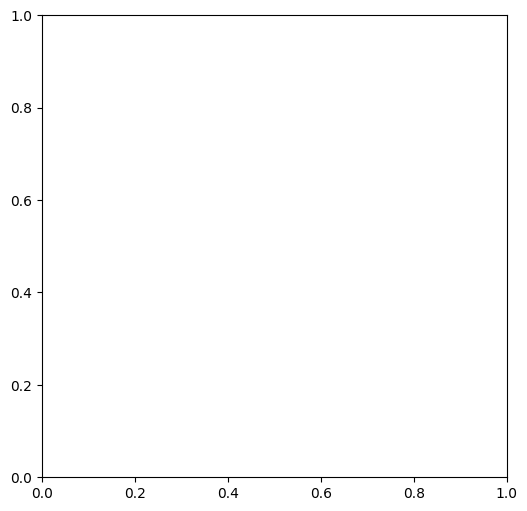

In [9]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuary_list, label='Train Accuracy')
plt.plot(test_accuary_list, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
